In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import anderson, levene, f_oneway, kruskal, ks_2samp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_train_extra = pd.read_csv('./data/training_extra.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
print(f'train shape: {df_train.shape}')
print(f'train_extra shape: {df_train_extra.shape}')
print(f'test shape: {df_test.shape}')

train shape: (300000, 11)
train_extra shape: (3694318, 11)
test shape: (200000, 10)


In [52]:
df_train.select_dtypes(include=['object', 'category']).columns

Index(['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof',
       'Style', 'Color'],
      dtype='object')

In [4]:
df_train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [5]:
df_train.tail()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080
299999,299999,Under Armour,Canvas,Small,2.0,No,Yes,Backpack,Black,18.568865,26.72762


In [6]:
df_test.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [7]:
df_test.tail()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
199995,499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498
199996,499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394
199997,499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163
199998,499998,Puma,Nylon,Large,10.0,Yes,No,Tote,Gray,25.769153
199999,499999,Under Armour,Leather,Medium,8.0,Yes,Yes,Messenger,Pink,29.175026


In [8]:
df_train_extra.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


### Helper function

In [9]:
def plot_bar(data, x_col, y_col, agg_func='mean', title=None, xlabel=None, ylabel=None):

    # Perform aggregation
    aggregated_data = data.groupby(x_col)[y_col].agg(agg_func).reset_index()

    # Plot the bar chart
    plt.figure(figsize=(5, 3))
    plt.bar(aggregated_data[x_col], aggregated_data[y_col], color='skyblue')
    plt.title(title if title else f'{agg_func.capitalize()} of {y_col} by {x_col}')
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else f'{agg_func.capitalize()} {y_col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_box(data, x_col, y_col, title=None, xlabel=None, ylabel=None):

    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)

    # Set plot titles and labels
    plt.title(title if title else f'Distribution of {y_col} by {x_col}')
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

## EDA

In [11]:
df_train.dtypes

id                        int64
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


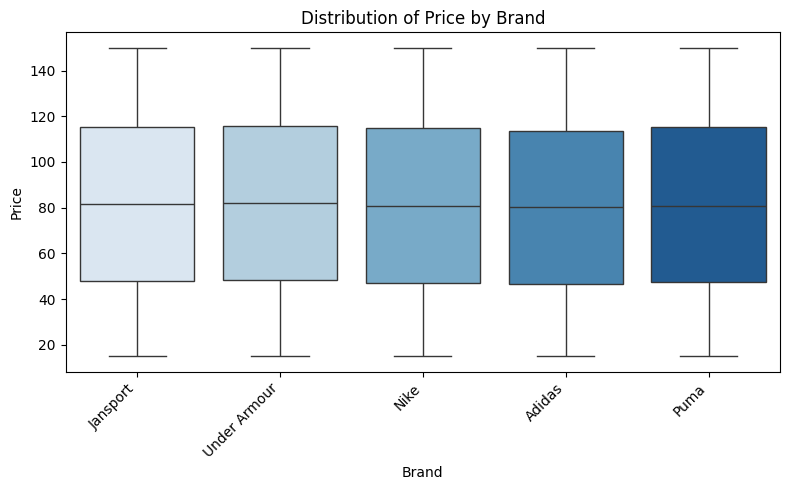

In [12]:
plot_box(df_train, 'Brand', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


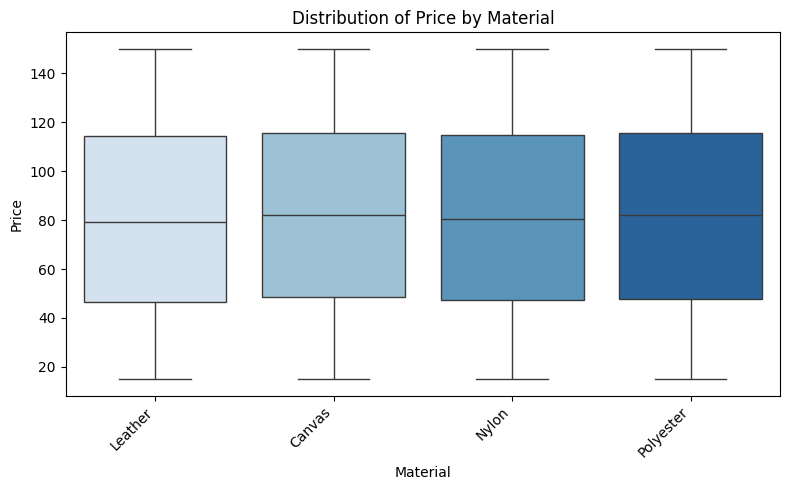

In [13]:
plot_box(df_train, 'Material', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


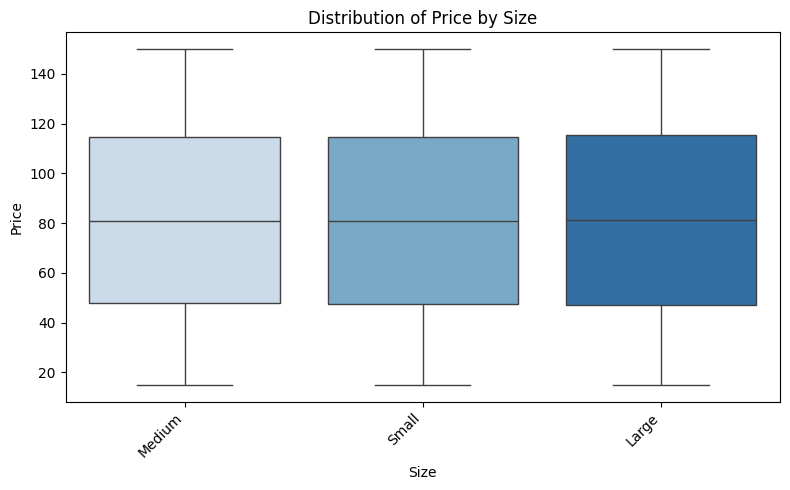

In [14]:
plot_box(df_train, 'Size', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


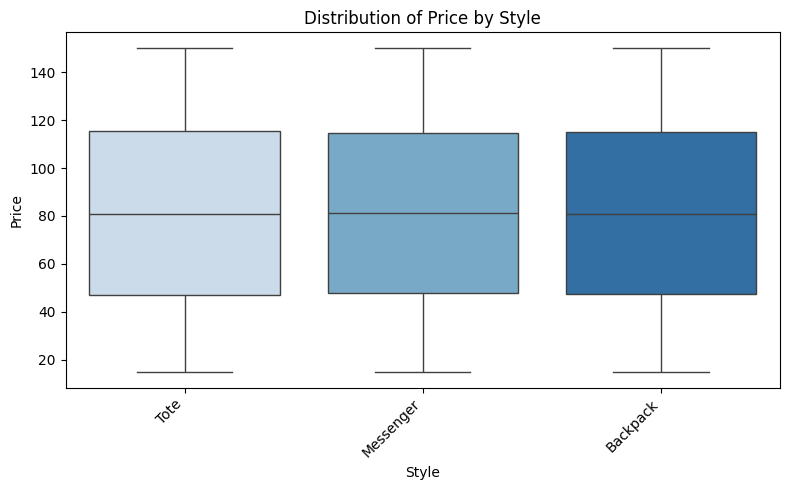

In [15]:
plot_box(df_train, 'Style', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


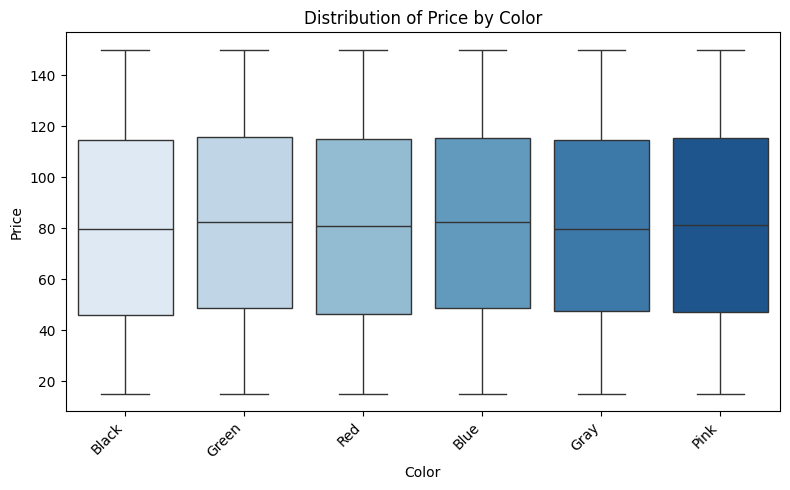

In [16]:
plot_box(df_train, 'Color', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


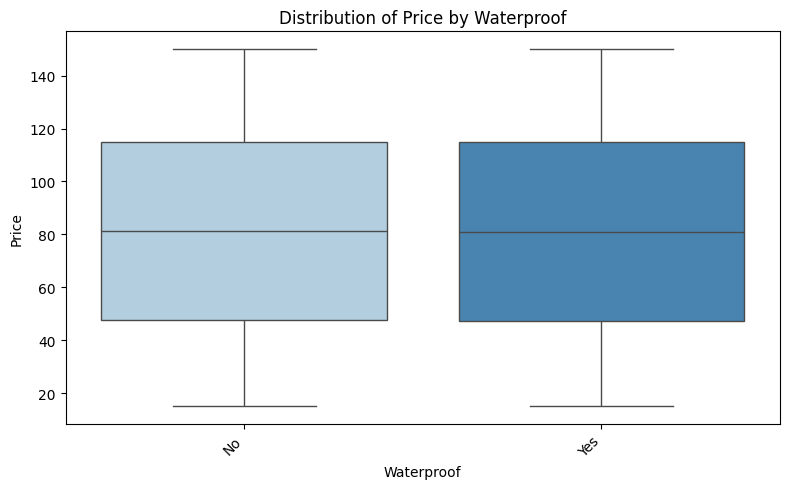

In [22]:
plot_box(df_train, 'Waterproof', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


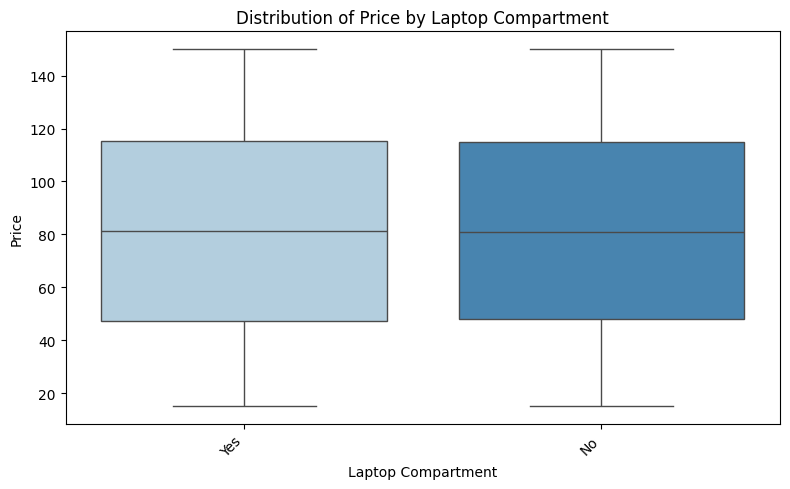

In [21]:
plot_box(df_train, 'Laptop Compartment', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


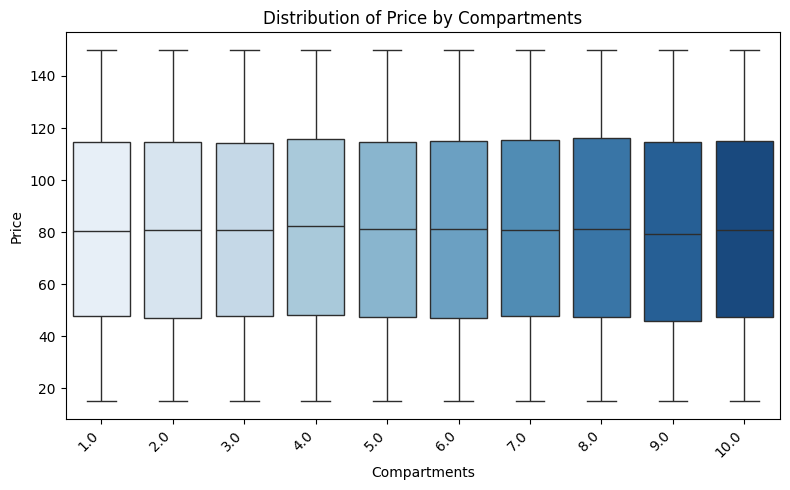

In [24]:
plot_box(df_train, 'Compartments', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


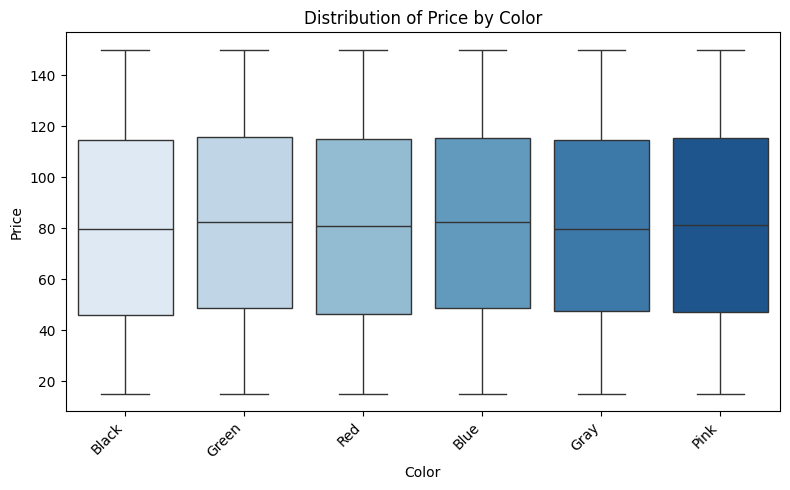

In [25]:
plot_box(df_train, 'Color', 'Price')

C:\Users\Sean\AppData\Local\Temp\ipykernel_240\1901648795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette="Blues", legend=False)


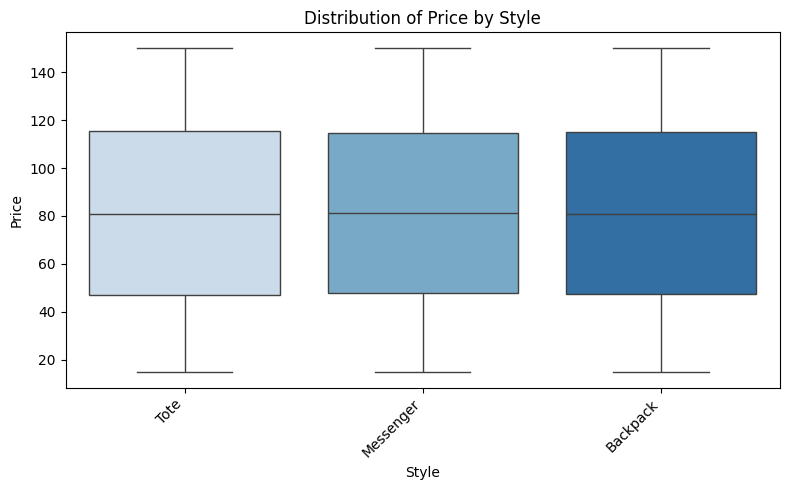

In [26]:
plot_box(df_train, 'Style', 'Price')

### Outliers check

In [ ]:
df = df_train.copy()

def detect_outliers_by_category(df, category_cols, price_col='Price'):
    category_outliers = []

    for category_col in category_cols:
        for category in df[category_col].unique():
            subset = df[df[category_col] == category].copy()

            if subset.shape[0] < 5:  # Skip categories with too few samples
                continue

            # Compute IQR for this category
            Q1 = subset[price_col].quantile(0.25)
            Q3 = subset[price_col].quantile(0.75)
            IQR = Q3 - Q1

            # Define outlier boundaries for this category
            lower_bound = 0 if (Q1 - 1.5 * IQR) < 0 else (Q1 - 1.5 * IQR)
            upper_bound = Q3 + 1.5 * IQR

            # Find outliers within this category
            category_anomalies = subset[(subset[price_col] < lower_bound) | (subset[price_col] > upper_bound)].copy()
            category_anomalies['Outlier_Category'] = category_col
            category_anomalies['Outlier_Value'] = category

            category_outliers.append(category_anomalies)

    # Combine all category outliers
    if category_outliers:
        return pd.concat(category_outliers)
    else:
        return pd.DataFrame()  # Return empty if no outliers fou


In [82]:
cate_cols = df_train.select_dtypes(include=['object', 'category']).columns
detect_outliers_by_category(df, category_cols=cate_cols)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Outlier_Category,Outlier_Value


### I want to test whether there is statistical significance in price based on brands, color, style ..etc

In [ ]:
def test_price_significance(df, category_col, price_col='Price'):
    """
    Test statistical significance of price differences across a categorical variable.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - category_col: Categorical column to test (e.g., 'Brand', 'Color', etc.).
    - price_col: Column representing price (default='Price').

    Returns:
    - Prints results of normality test, homogeneity test, ANOVA/Kruskal-Wallis, and post-hoc analysis.
    """
    
    print(f"\n🔍  Testing {price_col} differences across {category_col} ")
    
    # Remove missing values
    df = df[[category_col, price_col]].dropna()
    
    # Ensure category_col is treated as a categorical variable
    df[category_col] = df[category_col].astype(str)

    # Group prices by category
    grouped_data = [df[df[category_col] == cat][price_col] for cat in df[category_col].unique()]
    
    # Step 1: Normality Check (Anderson-Darling Test)
    normal_test_results = [anderson(group) for group in grouped_data if len(group) > 3]
    is_normal = all(res.statistic < res.critical_values[2] for res in normal_test_results)  # 5% significance level

    # Step 2: Homogeneity of Variance Check (Levene’s Test)
    stat, p_levene = levene(*grouped_data)
    is_homogeneous = p_levene > 0.05
    
    print(f"📌 Normality Test (Anderson-Darling): {'✅ Data is normal' if is_normal else '❌ Data is NOT normal'}")
    print(f"📌 Homogeneity of Variance (Levene’s Test): {'✅ Variances are equal' if is_homogeneous else '❌ Variances are NOT equal'}")

    # Step 3: Choose Statistical Test
    if is_normal and is_homogeneous:
        print("\n🚀 Performing One-Way ANOVA...")
        stat, p_value = f_oneway(*grouped_data)
    else:
        print("\n🚀 Performing Kruskal-Wallis Test (Non-Parametric)...")
        stat, p_value = kruskal(*grouped_data)
    
    print(f"🔹 Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("✅ Significant differences detected!")
    else:
        print("❌ No significant differences found.")

    # Step 4: Post Hoc Analysis
    if p_value < 0.05:
        print("\n📊 Performing Post-Hoc Analysis (Pairwise Comparisons)...")
        if is_normal:
            tukey = pairwise_tukeyhsd(df[price_col], df[category_col])
            print(tukey)
        else:
            dunn_test = sp.posthoc_dunn(df, val_col=price_col, group_col=category_col, p_adjust='bonferroni')
            print("\nDunn’s Test Results (p-values):\n", dunn_test)

    print("\n✅ Analysis Complete!\n")

In [42]:
test_price_significance(df_train, category_col='Brand')


🔍 **Testing Price differences across Brand**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 42.5629, p-value: 0.0000
✅ Significant differences detected!

📊 Performing Post-Hoc Analysis (Pairwise Comparisons)...

Dunn’s Test Results (p-values):
                     Adidas  Jansport      Nike      Puma  Under Armour
Adidas        1.000000e+00  0.000004  0.028472  0.003963  1.924885e-08
Jansport      4.212115e-06  1.000000  0.385822  1.000000  1.000000e+00
Nike          2.847230e-02  0.385822  1.000000  1.000000  3.169114e-02
Puma          3.962774e-03  1.000000  1.000000  1.000000  1.739006e-01
Under Armour  1.924885e-08  1.000000  0.031691  0.173901  1.000000e+00

✅ Analysis Complete!



In [43]:
test_price_significance(df_train, category_col='Material')


🔍 **Testing Price differences across Material**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 94.3978, p-value: 0.0000
✅ Significant differences detected!

📊 Performing Post-Hoc Analysis (Pairwise Comparisons)...

Dunn’s Test Results (p-values):
                  Canvas       Leather     Nylon     Polyester
Canvas     1.000000e+00  5.058636e-15  0.000002  1.000000e+00
Leather    5.058636e-15  1.000000e+00  0.023102  7.706586e-15
Nylon      1.680382e-06  2.310238e-02  1.000000  4.071802e-06
Polyester  1.000000e+00  7.706586e-15  0.000004  1.000000e+00

✅ Analysis Complete!



In [44]:
test_price_significance(df_train, category_col='Size')


🔍 **Testing Price differences across Size**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 2.9022, p-value: 0.2343
❌ No significant differences found.

✅ Analysis Complete!



In [45]:
test_price_significance(df_train, category_col='Compartments')


🔍 **Testing Price differences across Compartments**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 33.7052, p-value: 0.0001
✅ Significant differences detected!

📊 Performing Post-Hoc Analysis (Pairwise Comparisons)...

Dunn’s Test Results (p-values):
            1.0      10.0       2.0       3.0       4.0       5.0       6.0  \
1.0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2.0   1.000000  1.000000  1.000000  1.000000  0.512530  1.000000  1.000000   
3.0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4.0   1.000000  1.000000  0.512530  1.000000  1.000000  1.000000  1.000000   
5.0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
6.0   1.000000  1.000000  1.000000  1.000000  1.0

In [46]:
test_price_significance(df_train, category_col='Laptop Compartment')


🔍 **Testing Price differences across Laptop Compartment**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 0.0093, p-value: 0.9233
❌ No significant differences found.

✅ Analysis Complete!



In [47]:
test_price_significance(df_train, category_col='Waterproof')


🔍 **Testing Price differences across Waterproof**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 1.5892, p-value: 0.2074
❌ No significant differences found.

✅ Analysis Complete!



In [48]:
test_price_significance(df_train, category_col='Style')


🔍 **Testing Price differences across Style**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 0.0689, p-value: 0.9661
❌ No significant differences found.

✅ Analysis Complete!



In [49]:
test_price_significance(df_train, category_col='Color')


🔍 **Testing Price differences across Color**
📌 Normality Test (Anderson-Darling): ❌ Data is NOT normal
📌 Homogeneity of Variance (Levene’s Test): ❌ Variances are NOT equal

🚀 Performing Kruskal-Wallis Test (Non-Parametric)...
🔹 Test Statistic: 81.7788, p-value: 0.0000
✅ Significant differences detected!

📊 Performing Post-Hoc Analysis (Pairwise Comparisons)...

Dunn’s Test Results (p-values):
               Black          Blue          Gray         Green      Pink  \
Black  1.000000e+00  4.362230e-08  1.000000e+00  3.751614e-12  0.000106   
Blue   4.362230e-08  1.000000e+00  5.880161e-05  1.000000e+00  1.000000   
Gray   1.000000e+00  5.880161e-05  1.000000e+00  2.361878e-08  0.027365   
Green  3.751614e-12  1.000000e+00  2.361878e-08  1.000000e+00  0.037506   
Pink   1.063469e-04  1.000000e+00  2.736540e-02  3.750618e-02  1.000000   
Red    8.037543e-01  8.880183e-04  1.000000e+00  8.870725e-07  0.171119   

                Red  
Black  8.037543e-01  
Blue   8.880183e-04  
Gray   1.0

#  Analysis Summary 

##  1. Price Differences Across Brands 
-  Normality Test (Anderson-Darling):  ❌ *The data is not normally distributed.*
-  Homogeneity of Variance (Levene’s Test):  ❌ *Variances are not equal.*
- Given these violations of parametric test assumptions, a  non-parametric Kruskal-Wallis test  was used.
-  Kruskal-Wallis Test Result:  ✅ *Significant differences detected (p-value = 0.0000)*, meaning that at least one brand has a statistically different price distribution.
-  Post-Hoc Analysis (Dunn’s Test):  
  - Several pairwise comparisons have very small p-values (e.g., *Adidas vs. Jansport, Adidas vs. Under Armour*), indicating significant price differences between those brands.

##  2. Price Differences Across Material 
-  Normality Test (Anderson-Darling):  ❌ *The data is not normally distributed.*
-  Homogeneity of Variance (Levene’s Test):  ❌ *Variances are not equal.*
-  Kruskal-Wallis Test Result:  ✅ *Significant differences detected (p-value = 0.0000).*
-  Post-Hoc Analysis (Dunn’s Test): 
  - Significant price differences exist among *Canvas, Leather, Nylon, and Polyester* materials.

##  3. Price Differences Across Compartments 
-  Normality Test (Anderson-Darling):  ❌ *The data is not normally distributed.*
-  Homogeneity of Variance (Levene’s Test):  ❌ *Variances are not equal.*
-  Kruskal-Wallis Test Result:  ✅ *Significant differences detected (p-value = 0.0001).*
-  Post-Hoc Analysis (Dunn’s Test): 
  - Several compartment configurations show  statistically significant  price differences.

##  4. Price Differences Across Colors 
-  Normality Test (Anderson-Darling):  ❌ *The data is not normally distributed.*
-  Homogeneity of Variance (Levene’s Test):  ❌ *Variances are not equal.*
-  Kruskal-Wallis Test Result:  ✅ *Significant differences detected (p-value = 0.0000).*
-  Post-Hoc Analysis (Dunn’s Test): 
  - Specific colors (*Black, Blue, Gray, Green, Pink, Red*) have significant price differences.

##  5. Features That Do Not Significantly Affect Price 
The following categorical variables  do not  show significant price differences:
-  Size  ❌ *(p-value = 0.2343)*
-  Laptop Compartment  ❌ *(p-value = 0.9233)*
-  Waterproof  ❌ *(p-value = 0.2074)*
-  Style  ❌ *(p-value = 0.9661)*

##  Overall Conclusion 
-  Brand, material, compartments, and color significantly impact price. 
-  Size, laptop compartment, waterproof, and style do not have a significant impact on price. 
-  Data does not meet parametric test assumptions,  requiring non-parametric statistical methods.
-  Certain categories show highly significant differences,  suggesting that some features strongly influence pricing.
-  No outliers in each categorical features


## Modeling Strategies

1. build up the base line model
2. remove some columns(size, laptop compartment, waterproof, style) one by one to see if the performance is enhanced.